<IMG SRC="https://avatars2.githubusercontent.com/u/31697400?s=400&u=a5a6fc31ec93c07853dd53835936fd90c44f7483&v=4" WIDTH=125 ALIGN="right">


# NLmod examples  

This example notebook shows a basic example of a model created with the `nlmod` package. The `nlmod` package contains functions to create modflow models anywhere in the Netherlands.

### Contents<a name="TOC"></a>
1. [Create model](#create)
2. [Run model](#run)
3. [Visualise](#visualise)

In [1]:
import matplotlib.pyplot as plt
import flopy
import os
import geopandas as gpd

import nlmod

import logging

In [2]:
print(f'nlmod version: {nlmod.__version__}')

# toon informatie bij het aanroepen van functies
logging.basicConfig(level=logging.INFO)

nlmod version: 0.2.4b


### [1. Create model](#TOC)<a name="create"></a>

With the code below we create a modflow model with the name 'IJmuiden'. This model has the following properties :
- an extent that covers part of the Northsea, Noordzeekanaal and the small port city IJmuiden.
- a structured grid based on the subsurface models [Regis](https://www.dinoloket.nl/regis-ii-het-hydrogeologische-model) and [Geotop](https://www.dinoloket.nl/detaillering-van-de-bovenste-lagen-met-geotop). The Regis layers that are not present within the extent are removed. In this case we use b'MSz1' as the bottom layer of the model. Use `nlmod.regis.get_layer_names()` to get all the layer names of Regis. All Regis layers below this layer are not used in the model. Geotop is used to replace the holoceen layer in Regis because there is no kh or kv defined for the holoceen in Regis. Part of the model is in the North sea. Regis and Geotop have no data there. Therefore the Regis and Geotop layers are extrapolated from the shore and the seabed is added using bathymetry data from [Jarkus](https://www.openearth.nl/rws-bathymetry/2018.html).
- starting heads of 1 in every cell.
- the model is a steady state model of a single time step.
- big surface water bodies (Northsea, IJsselmeer, Markermeer, Noordzeekanaal) within the extent are added as a general head boundary. The surface water bodies are obtained from a [shapefile](..\data\opp_water.shp).
- surface drainage is added using [ahn](https://www.ahn.nl) data and a default conductance of $1000 m^2/d$
- recharge is added using data from the [knmi](https://www.knmi.nl/nederland-nu/klimatologie/daggegevens) using the following steps:~~
    1. Check for each cell which KNMI weather and/or rainfall station is closest.
    2. Download the data for the stations found in 1. for the model period. For a steady state stress period the average precipitation and evaporation of 8 years before the stress period time is used.
    3. Combine precipitation and evaporation data from step 2 to create a recharge time series for each cell
    4. Add the timeseries to the model dataset and create the recharge package.
- constant head boundaries are added to the model edges in every layer. The starting head is used as constant head.

In [3]:
# model settings
model_ws = 'model1'
model_name = 'IJmuiden'
figdir, cachedir = nlmod.util.get_model_dirs(model_ws)
extent = [95000., 105000., 494000., 500000.]
delr = 100.
delc = 100.
steady_state = True
start_time = '2015-1-1'
gridtype = 'structured'
use_regis = True
regis_botm_layer = 'MSz1'
use_geotop = True
add_northsea = True
starting_head = 1.0

In [4]:
# layer model
layer_model = nlmod.read.regis.get_combined_layer_models(extent,
                                                         use_regis=use_regis,
                                                         regis_botm_layer=regis_botm_layer,
                                                         use_geotop=use_geotop,
                                                         cachedir=cachedir,
                                                         cachename='combined_layer_ds.nc')

INFO:nlmod.read.geotop:slice geotop with regis layer HLc
INFO:nlmod.read.geotop:create kh matrix from lithoklasse and csv file
INFO:nlmod.read.geotop:creating top and bot per geo eenheid
INFO:nlmod.read.geotop:1000.0
INFO:nlmod.read.geotop:1020.0
INFO:nlmod.read.geotop:1030.0
INFO:nlmod.read.geotop:1040.0
INFO:nlmod.read.geotop:1050.0
INFO:nlmod.read.geotop:1100.0
INFO:nlmod.read.geotop:1120.0
INFO:nlmod.read.geotop:1130.0
INFO:nlmod.read.geotop:3030.0
INFO:nlmod.read.geotop:3100.0
INFO:nlmod.read.geotop:4010.0
INFO:nlmod.read.geotop:adding stroombanen to top and bot of each layer
INFO:nlmod.read.geotop:get kh for each layer
INFO:nlmod.read.geotop:AAOP
INFO:nlmod.read.geotop:NASC
INFO:nlmod.read.geotop:ONAWA
INFO:nlmod.read.geotop:NAZA
INFO:nlmod.read.geotop:NAWA
INFO:nlmod.read.geotop:NAWO
INFO:nlmod.read.geotop:NAWOVE
INFO:nlmod.read.geotop:NIBA
INFO:nlmod.read.geotop:BXWISIKO
INFO:nlmod.read.geotop:BX
INFO:nlmod.read.geotop:KRBXDE
INFO:nlmod.read.regis:cut geotop layer based on regi

In [5]:
layer_model

<xarray.Dataset>
Dimensions:  (y: 60, x: 100, layer: 83)
Coordinates:
  * y        (y) float64 4.94e+05 4.942e+05 4.942e+05 ... 4.998e+05 5e+05
  * x        (x) float64 9.505e+04 9.515e+04 9.525e+04 ... 1.048e+05 1.05e+05
  * layer    (layer) object 'AAOP' 'NASC' 'ONAWA' ... 'PZc' 'PZWAz4' 'MSz1'
Data variables:
    top      (layer, y, x) float64 nan nan nan nan ... -232.8 -233.1 -233.3
    botm     (layer, y, x) float64 nan nan nan nan ... -233.5 -233.8 -234.0
    kh       (layer, y, x) float64 nan nan nan nan nan ... 6.19 6.19 6.18 6.17
    kv       (layer, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/40)
    references:                    https://www.dinoloket.nl/regis-ii-het-hydr...
    Conventions:                   CF-1.7
    creator_url:                   https://www.dinoloket.nl
    keywords_vocabulary:           NASA/GCMD Earth Science Keywords. Version 6.0
    acknowledgment:                https://www.dinoloket.nl
    project:                       REGIS v02r2
    ...                            ...
    geospatial_lon_resolution:     0.0014573401
    geospatial_vertical_min:       -1235.92
    geospatial_vertical_max:       322.75
    geospatial_vertical_units:     m-NAP
    geospatial_vertical_positive:  up
    extent:                        [95000.0, 105000.0, 494000.0, 500000.0]

In [6]:
# create a model ds by changing grid of layer_model
model_ds = nlmod.read.regis.to_model_ds(layer_model, model_name, model_ws, delr=delr, delc=delc)

# add time discretisation
model_ds = nlmod.mdims.set_model_ds_time(model_ds,
                                         start_time=start_time,
                                         steady_state=steady_state, perlen=365*5)

if add_northsea:
    model_ds = nlmod.mdims.add_northsea(model_ds)

INFO:nlmod.read.regis:redefining current extent: [95000.0, 105000.0, 494000.0, 500000.0], fit to regis raster
INFO:nlmod.read.regis:new extent is [95000.0, 105000.0, 494000.0, 500000.0] model has 60 rows and 100 columns
INFO:nlmod.read.regis:find active layers in raw layer model
INFO:nlmod.read.regis:there are 40 active layers within the extent
INFO:nlmod.read.regis:removing 40 nan layers from the model
INFO:nlmod.read.regis:resample regis data to structured modelgrid
INFO:nlmod.mdims.mgrid:get first active modellayer for each cell in idomain
INFO:nlmod.mdims.mlayers:nan values at the northsea are filled using the bathymetry from jarkus
C:\Users\ruben\miniconda3\envs\artesia\lib\site-packages\flopy\utils\gridintersect.py:276: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)
INFO:nlmod.mdims.mgrid:get first active modellayer for each cell in idomain


In [7]:
# create modflow packages
sim, gwf = nlmod.mfpackages.sim_tdis_gwf_ims_from_model_ds(model_ds)

# Create discretization
nlmod.mfpackages.dis_from_model_ds(model_ds, gwf)

# create node property flow
nlmod.mfpackages.npf_from_model_ds(model_ds, gwf)

# Create the initial conditions package
nlmod.mfpackages.ic_from_model_ds(model_ds, gwf, starting_head=starting_head)

# Create the output control package
nlmod.mfpackages.oc_from_model_ds(model_ds, gwf);

INFO:nlmod.mfpackages.mfpackages:creating modflow SIM, TDIS, GWF and IMS


In [8]:
# voeg grote oppervlaktewaterlichamen toe o.b.v. rws shape
da_name = 'rws_oppwater'
rws_ds = nlmod.read.rws.get_surface_water(model_ds,
                                           da_name,
                                           cachedir=model_ds.cachedir,
                                           cachename=da_name)
model_ds.update(rws_ds)
ghb = nlmod.mfpackages.ghb_from_model_ds(model_ds, gwf, da_name)

C:\Users\ruben\miniconda3\envs\artesia\lib\site-packages\flopy\utils\gridintersect.py:276: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)
C:\Users\ruben\miniconda3\envs\artesia\lib\site-packages\flopy\utils\gridintersect.py:276: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)
C:\Users\ruben\miniconda3\envs\artesia\lib\site-packages\flopy\utils\gridintersect.py:276: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = (i, j)
INFO:nlmod.cache:caching data -> rws_oppwater.nc


In [9]:
# surface level drain
ahn_ds = nlmod.read.ahn.get_ahn(model_ds, cachedir=model_ds.cachedir, cachename='ahn')
model_ds.update(ahn_ds)

drn = nlmod.mfpackages.surface_drain_from_model_ds(model_ds, gwf)


# add constant head cells at model boundaries
model_ds.update(nlmod.mfpackages.constant_head.get_chd_at_model_edge(model_ds, model_ds['idomain']))    
chd = nlmod.mfpackages.chd_from_model_ds(model_ds, gwf, head='starting_head')

INFO:nlmod.read.ahn:- download ahn between: x (95000.0, 105000.0); y (494000.0, 500000.0)
INFO:nlmod.cache:caching data -> ahn.nc


In [10]:
# add knmi recharge to the model datasets
knmi_ds = nlmod.read.knmi.get_recharge(model_ds, cachedir=model_ds.cachedir, cachename='recharge')
model_ds.update(knmi_ds)

# create recharge package
rch = nlmod.mfpackages.rch_from_model_ds(model_ds, gwf)

INFO:hydropandas.io.io_knmi:download knmi RD data from station 226-WIJK-AAN-ZEE between 2015-01-01 00:00:00 and 2020-01-01 00:00:00
INFO:hydropandas.io.io_knmi:station 226 has 0 missing measurements
INFO:hydropandas.io.io_knmi:download knmi RD data from station 263-ASSENDELFT between 2015-01-01 00:00:00 and 2020-01-01 00:00:00
INFO:hydropandas.io.io_knmi:station 263 has 0 missing measurements
INFO:hydropandas.io.io_knmi:download knmi RD data from station 225-OVERVEEN between 2015-01-01 00:00:00 and 2020-01-01 00:00:00
INFO:hydropandas.io.io_knmi:station 225 has 0 missing measurements
INFO:hydropandas.io.io_knmi:download knmi EV24 data from station 257-WIJK-AAN-ZEE between 2015-01-01 00:00:00 and 2020-01-01 00:00:00
INFO:hydropandas.io.io_knmi:station 257 has 0 missing measurements
INFO:nlmod.cache:caching data -> recharge.nc


A big part of the model data is stored in the variable `model_ds` which is an `xarray.Dataset`. The data is shown below.

In [11]:
model_ds

<xarray.Dataset>
Dimensions:             (layer: 40, y: 60, x: 100, time: 1)
Coordinates:
  * layer               (layer) object 'AAOP' 'NASC' 'ONAWA' ... 'PZWAz4' 'MSz1'
  * x                   (x) float64 9.505e+04 9.515e+04 ... 1.048e+05 1.05e+05
  * y                   (y) float64 5e+05 4.998e+05 ... 4.942e+05 4.94e+05
  * time                (time) datetime64[ns] 2019-12-31
Data variables: (12/16)
    top                 (y, x) float64 -19.0 -18.51 -18.51 ... 1.49 0.5 0.37
    botm                (layer, y, x) float64 -19.0 -18.51 ... -218.2 -218.5
    kh                  (layer, y, x) float64 1.0 1.0 1.0 1.0 ... 6.1 6.11 6.11
    kv                  (layer, y, x) float64 0.1 0.1 0.1 ... 0.61 0.611 0.611
    idomain             (layer, y, x) int32 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1
    first_active_layer  (y, x) int32 -999 -999 -999 -999 -999 -999 ... 0 0 0 0 0
    ...                  ...
    rws_oppwater_area   (y, x) float64 1e+04 1e+04 1e+04 1e+04 ... 0.0 0.0 0.0
    rws_oppwater_cond   (y, x) float64 1e+03 1e+03 1e+03 1e+03 ... 0.0 0.0 0.0
    rws_oppwater_peil   (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ahn                 (y, x) float64 nan nan nan nan ... 1.971 nan nan 0.2378
    chd                 (layer, y, x) int32 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1
    recharge            (y, x) float64 0.0 0.0 0.0 ... 0.0007675 0.0007675
Attributes: (12/13)
    gridtype:                  structured
    extent:                    [95000.0, 105000.0, 494000.0, 500000.0]
    delr:                      100.0
    delc:                      100.0
    model_name:                IJmuiden
    mfversion:                 mf6
    ...                        ...
    exe_name:                  c:\users\ruben\documents\github\nlmod\nlmod\md...
    model_ws:                  model1
    figdir:                    model1\figure
    cachedir:                  model1\cache
    nodata:                    -999
    surface_drn_cond:          1000

### [2. Write and Run](#TOC)<a name="run"></a>
Now that we've created all the modflow packages we need to write them to modflow files. You always have to write the modflow data to the model workspace before you can run the model. You can write the model files and run the model using the function `nlmod.util.write_and_run_model()` as shown below. This function has two additional options:
1. Write the model dataset to the disk if `write_model_ds` is `True`. This makes it easier and faster to load model data if you ever need it. 
2. Write a copy of this Jupyter Notebook to the same directory as the modflow files if `nb_path` is the name of this Jupyter Notebook. It can be useful to have a copy of the script that created the modflow files, together with the files. 

In [12]:
nlmod.util.write_and_run_model(gwf, model_ds, write_model_ds=True, nb_path='01_basic_model.ipynb')

INFO:nlmod.util:write script 2022070401_basic_model.ipynb to model workspace
INFO:nlmod.util:write model dataset to cache
INFO:nlmod.util:write modflow files to model workspace


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model IJmuiden...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package oc...
    writing package ghb_0...
    writing package drn_0...
    writing package chd...
    writing package ijmuiden...


INFO:nlmod.util:run model


FloPy is using the following executable to run the model: c:\users\ruben\documents\github\nlmod\nlmod\mfpackages\..\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/04/2022

   MODFLOW 6 compiled Mar 07 2022 16:14:29 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition 

### [3. Visualise](#TOC)<a name="visualise"></a>

Using the `model_ds` and `gwf` variables it is quite easy to visualise model data. Below the modelgrid together with the surface water is shown.

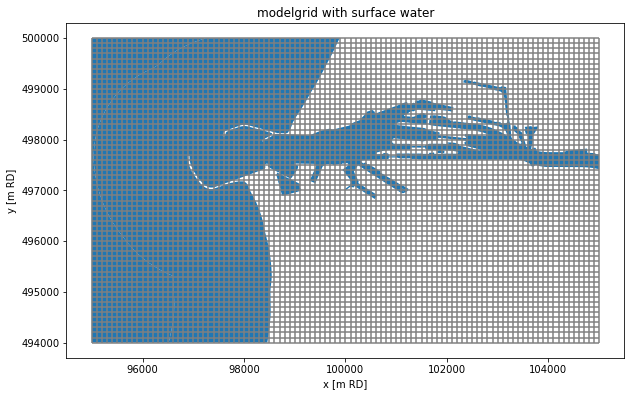

In [13]:
ax = nlmod.visualise.plots.plot_modelgrid(model_ds, gwf)
ax.figure.savefig(os.path.join(model_ds.figdir, 'mgrid_swater.png'), bbox_inches='tight')

Data from a model with a structured grid can be easily visualised using the model dataset. Below some examples

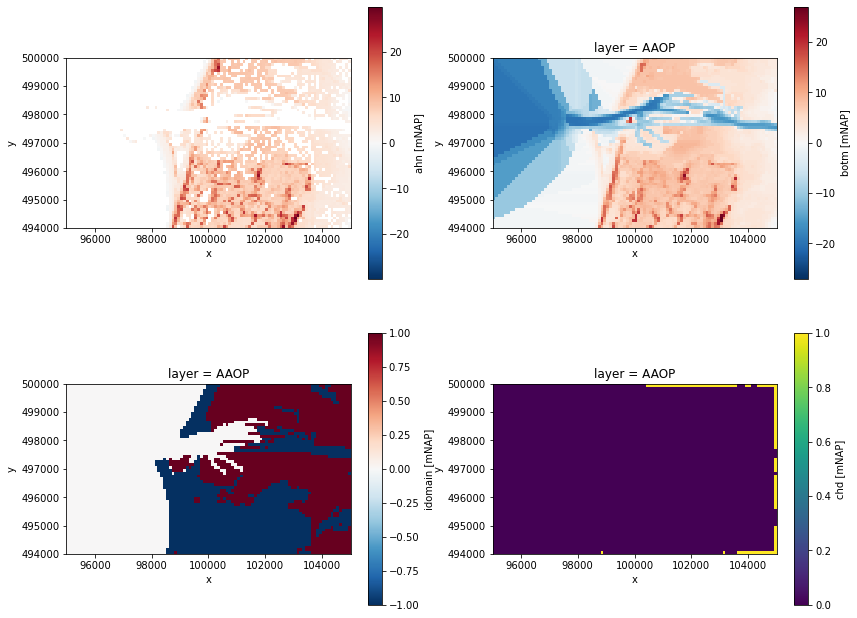

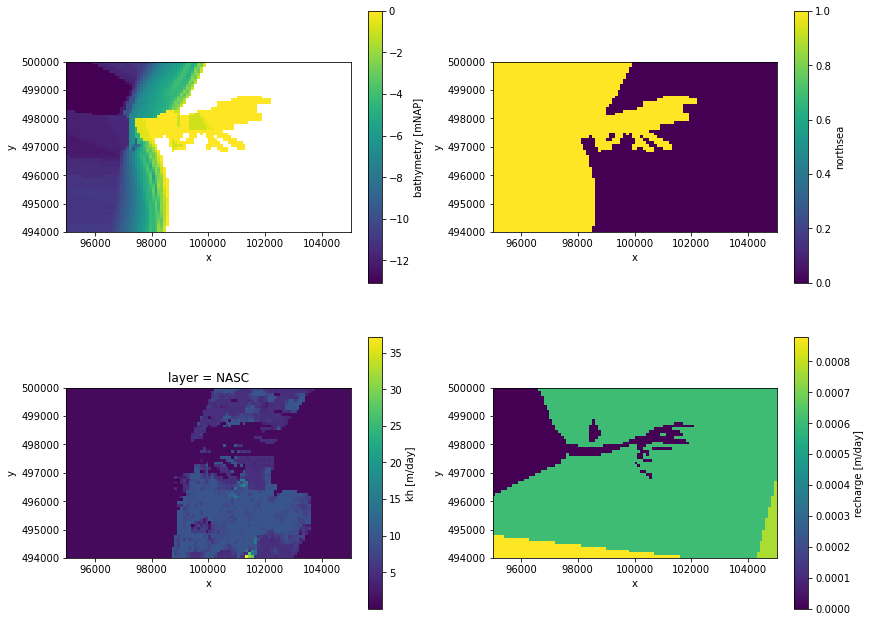

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 11))
model_ds['ahn'].plot(ax=axes[0][0])
model_ds['botm'][0].plot(ax=axes[0][1])
model_ds['idomain'][0].plot(ax=axes[1][0])
model_ds['chd'][0].plot(ax=axes[1][1])
for axes1 in axes:
    for ax in axes1:
        ax.axis('scaled')

fig.savefig(os.path.join(model_ds.figdir, 'ahn_bot_idom_chd.png'), bbox_inches='tight')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 11))
model_ds['bathymetry'].plot(ax=axes[0][0])
model_ds['northsea'].plot(ax=axes[0][1])
model_ds['kh'][1].plot(ax=axes[1][0])
model_ds['recharge'].plot(ax=axes[1][1])

for axes1 in axes:
    for ax in axes1:
        ax.axis('scaled')
fig.savefig(os.path.join(model_ds.figdir, 'bath_nsea_kh_top.png'), bbox_inches='tight')